## 라이브러리 가져오기

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 데이터셋 불러오기

In [2]:
data = np.loadtxt('data.txt')

data = (data - data.mean(axis=0)) / data.std(axis=0)

data = np.repeat(data, 25, axis=0)

data.shape

(102500, 2)

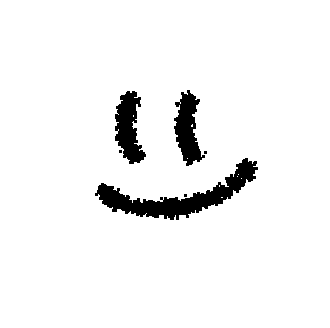

In [3]:
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c='black', s=1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axis('off')
plt.show()

## 학습용 데이터로 만들기

In [4]:
X = torch.tensor(data, dtype=torch.float32)
X.shape

torch.Size([102500, 2])

## Hyperparameters for Diffusion Model

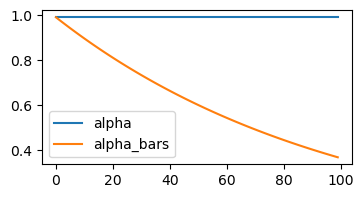

In [5]:
T = 100
timesteps = torch.tensor(range(0, T), dtype=torch.float32)


betas = torch.linspace(0.01, 0.01, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, 0)


plt.figure(figsize=(4, 2))
plt.plot(alphas, label='alpha')
plt.plot(alpha_bars, label='alpha_bars')
plt.legend()
plt.show()

## Forward Process 정의

In [6]:
def q_xt_x0(x0, t):
    epsilon = torch.randn(size=x0.shape)
    
    xt = torch.sqrt(alpha_bars[t]).repeat(1, x0.shape[1]) * x0 + \
        torch.sqrt(1 - alpha_bars[t]).repeat(1, x0.shape[1]) * epsilon
    
    return xt, epsilon

## Diffusion Model

In [7]:
class DiffusionBlock(nn.Module):
    def __init__(self, n_units):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(n_units, n_units)
    
    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)
        return x

In [8]:
class DiffusionModel(nn.Module):
    def __init__(self, n_features, n_blocks=4, n_units=64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(n_features + 1, n_units)
        self.midblocks = nn.ModuleList([DiffusionBlock(n_units) for _ in range(n_blocks)])
        self.outblock = nn.Linear(n_units, n_features)
    
    def forward(self, x, t):
        x = torch.hstack([x, t])
        x = self.inblock(x)
        for midblock in self.midblocks:
            x = midblock(x)
        x = self.outblock(x)
        return x

In [9]:
model = DiffusionModel(n_features=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

## Training

In [10]:
epochs = 200
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

pbar = tqdm(range(epochs), total=epochs, leave=False)


for epoch in pbar:
    epoch_loss = steps = 0
    
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size]
        
        t = torch.randint(0, T, size=[len(X_batch), 1])
        
        xt, eps = q_xt_x0(X_batch, t)
        
        
        eps_theta = model(xt.to(device), t.to(device))
        
        loss = loss_fn(eps_theta, eps.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        steps += 1
    
    pbar.set_description(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / steps:.4f}")
    pbar.update(1)

pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

## Sampling

In [11]:
def sample(model, n_samples, n_features):
    with torch.no_grad():
        x = torch.randn(size=(n_samples, n_features)).to(device)
        
        xt = [x]
        
        for t in range(T-1, -1, -1):
            eps_theta = model(x, torch.full([n_samples, 1], t).to(device))
            
            
            x = 1 / torch.sqrt(alphas[t]) * (x - (1 - alphas[t]) / torch.sqrt(1 - alpha_bars[t]) * eps_theta)

            sigma = betas[t]
            std = torch.sqrt(sigma)
            x += std * torch.randn(size=(n_samples, n_features)).to(device)
            xt += [x]
        
        return x, xt

In [12]:
Xgen, Xgen_hist = sample(model, 10000, 2)
Xgen = Xgen.cpu()

MovieWriter imagemagick unavailable; using Pillow instead.


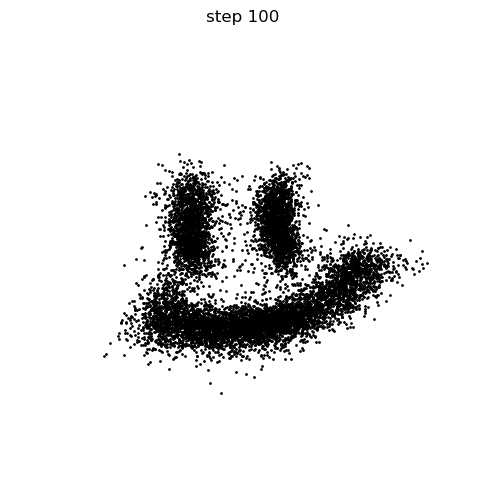

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

def draw_frame(i):
    ax.clear()
    Xvis = Xgen_hist[i].cpu()
    fig = ax.scatter(Xvis[:, 0], Xvis[:, 1], c='black', s=1, animated=True)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.axis('off')
    ax.set_title(f'step {i+1}')
    return fig,

frames = list(range(T)) + [T-1] * 100

anim = animation.FuncAnimation(fig, draw_frame, frames=frames, interval=50, blit=True)

anim.save('DDPM_sampling.gif', writer='imagemagick', fps=20)